<a href="https://colab.research.google.com/github/ShubhamX12/Deep-learning-/blob/main/Copy_of_convmixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/AlzimerSVMModel/Preprocessd', output="output", ratio=(.75,0,0.25)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ValueError: ignored

In [ ]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 4800 files belonging to 4 classes.


In [ ]:
train_ds_images = [images for images, _ in train_ds.unbatch()]
train_ds_labels = [labels for _, labels in train_ds.unbatch()]
train_ds_images = np.array(train_ds_images)
train_ds_labels = np.array(train_ds_labels)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=16
)

Found 1600 files belonging to 4 classes.


In [ ]:
test_ds_images = [images for images, _ in test_ds.unbatch()]
test_ds_labels = [labels for _, labels in test_ds.unbatch()]
test_ds_images = np.array(test_ds_images)
test_ds_labels = np.array(test_ds_labels)

In [ ]:
class_names = train_ds.class_names
print(test_ds_images.shape,test_ds_labels.shape)
print(class_names)

(1600, 32, 32, 3) (1600,)
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

## Hyperparameters

To keep run time short, we will train the model for only 10 epochs. To focus on
the core ideas of ConvMixer, we will not use other training-specific elements like
RandAugment ([Cubuk et al.](https://arxiv.org/abs/1909.13719)). If you are interested in
learning more about those details, please refer to the
[original paper](https://openreview.net/pdf?id=TVHS5Y4dNvM).

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 150

## Load the CIFAR-10 dataset

In [ ]:
x_train=train_ds_images
y_train=train_ds_labels
x_test=test_ds_images
y_test=test_ds_labels
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 4320
Validation data samples: 480
Test data samples: 1600


## Prepare `tf.data.Dataset` objects

Our data augmentation pipeline is different from what the authors used for the CIFAR-10
dataset, which is fine for the purpose of the example.

In [ ]:
image_size = 32
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

## ConvMixer utilities

The following figure (taken from the original paper) depicts the ConvMixer model:

![](https://i.imgur.com/yF8actg.png)

ConvMixer is very similar to the MLP-Mixer, model with the following key
differences:

* Instead of using fully-connected layers, it uses standard convolution layers.
* Instead of LayerNorm (which is typical for ViTs and MLP-Mixers), it uses BatchNorm.

Two types of convolution layers are used in ConvMixer. **(1)**: Depthwise convolutions,
for mixing spatial locations of the images, **(2)**: Pointwise convolutions (which follow
the depthwise convolutions), for mixing channel-wise information across the patches.
Another keypoint is the use of *larger kernel sizes* to allow a larger receptive field.

In [ ]:

def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


The model used in this experiment is termed as **ConvMixer-256/8** where 256 denotes the
number of channels and 8 denotes the depth. The resulting model only has 0.8 million
parameters.

## Model training and evaluation utility

In [ ]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model


## Train and evaluate model

In [ ]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/150
34/34 [==============================] - 21s 239ms/step - loss: 2.0750 - accuracy: 0.4069 - val_loss: 1.7176 - val_accuracy: 0.4938
Epoch 2/150
34/34 [==============================] - 7s 211ms/step - loss: 1.3815 - accuracy: 0.4954 - val_loss: 1.1741 - val_accuracy: 0.4938
Epoch 3/150
34/34 [==============================] - 7s 217ms/step - loss: 1.1027 - accuracy: 0.4956 - val_loss: 1.0754 - val_accuracy: 0.4938
Epoch 4/150
34/34 [==============================] - 7s 211ms/step - loss: 1.0632 - accuracy: 0.5005 - val_loss: 1.0763 - val_accuracy: 0.4938
Epoch 5/150
34/34 [==============================] - 7s 214ms/step - loss: 1.0497 - accuracy: 0.5007 - val_loss: 1.0635 - val_accuracy: 0.4938
Epoch 6/150
34/34 [==============================] - 7s 216ms/step - loss: 1.0372 - accuracy: 0.5016 - val_loss: 1.0798 - val_accuracy: 0.4938
Epoch 7/150
34/34 [==============================] - 7s 218ms/step - loss: 1.0295 - accuracy: 0.5023 - val_loss: 1.1067 - val_accuracy: 0.356

The gap in training and validation performance can be mitigated by using additional
regularization techniques. Nevertheless, being able to get to ~83% accuracy within 10
epochs with 0.8 million parameters is a strong result.

## Visualizing the internals of ConvMixer

We can visualize the patch embeddings and the learned convolution filters. Recall
that each patch embedding and intermediate feature map have the same number of channels
(256 in this case). This will make our visualization utility easier to implement.

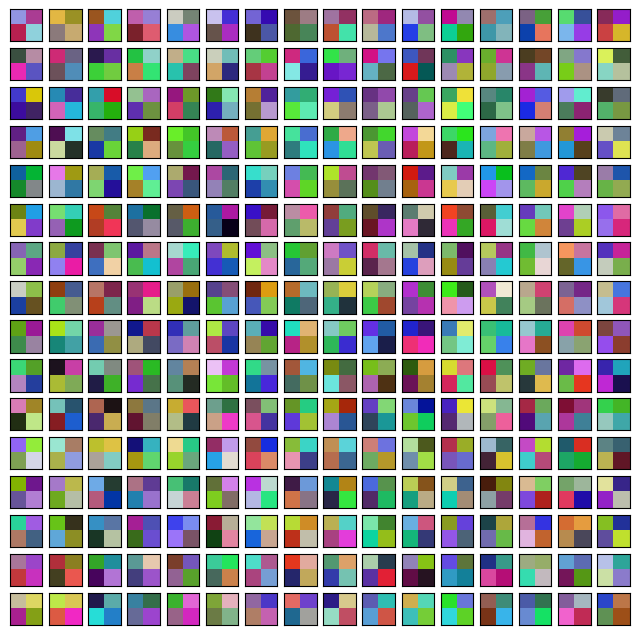

In [ ]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

Even though we did not train the network to convergence, we can notice that different
patches show different patterns. Some share similarity with others while some are very
different. These visualizations are more salient with larger image sizes.

Similarly, we can visualize the raw convolution kernels. This can help us understand
the patterns to which a given kernel is receptive.

5 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe62ae55690>
12 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe6a01b3190>
19 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe6a01fb880>
26 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe6a02313f0>
33 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe62add03a0>
40 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe62ae0f5e0>
47 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe62ae0cc70>
54 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fe62ae1ed10>


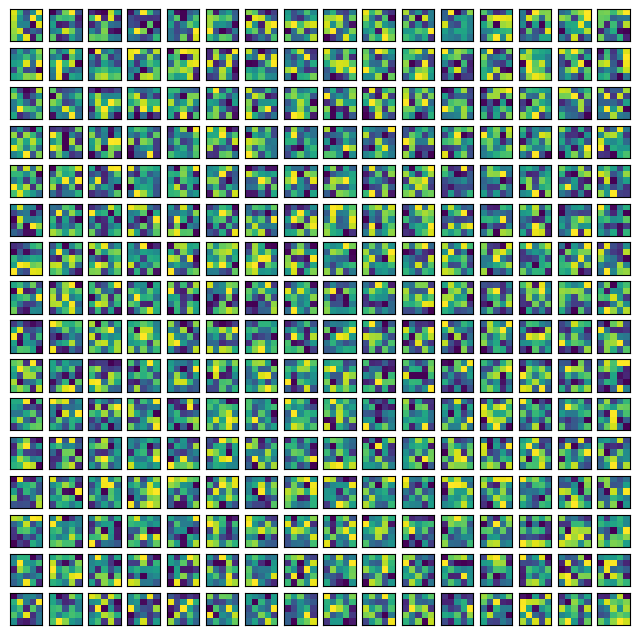

In [ ]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

We see that different filters in the kernel have different locality spans, and this pattern
is likely to evolve with more training.

## Final notes

There's been a recent trend on fusing convolutions with other data-agnostic operations
like self-attention. Following works are along this line of research:

* ConViT ([d'Ascoli et al.](https://arxiv.org/abs/2103.10697))
* CCT ([Hassani et al.](https://arxiv.org/abs/2104.05704))
* CoAtNet ([Dai et al.](https://arxiv.org/abs/2106.04803))

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-ConvMixer-black.svg)](https://huggingface.co/keras-io/conv_Mixer) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-ConvMixer-black.svg)](https://huggingface.co/spaces/keras-io/conv_Mixer) |